# 4.3 Storage Units: Learning Temporal Bidding Strategies

**Introduction**

In this tutorial, we extend the **reinforcement learning (RL)** framework to **storage units**, such as batteries, which face a unique decision structure: they must **buy energy (charge) when prices are low** and **sell it (discharge) when prices are high**, across multiple time steps.

This creates a **temporal coupling** of actions and rewards. Unlike generators that can profit immediately from selling electricity and are only time-coupled due to technical constraints (ramping, shut down etc), storage units must learn to plan ahead, accepting short-term costs in anticipation of future gains. As such, both the **observation space** and **reward design** need to reflect this temporal structure.

The tutorial is again designed to walk you through the essential components required to transform a conventional storage into an RL agent. Rather than concentrating on the underlying algorithmic infrastructure—such as training loops, buffers, or learning roles—this tutorial emphasizes **how to define a bidding strategy that interfaces with the ASSUME learning backend**. You will learn how to construct observation spaces, define action mappings, and design reward functions that guide agent behavior, but this time for a storage unit. If you have done the [04b_RL_example](.\04b_reinforcement_learning_example.ipynb) some parts will be familiar, since this is designed as a stand-alone tutorial as well. Mainly step 1. **ASSUME & Learning Basics** and 2. **Get ASSUME Running** can be skipped.

Each core concept is addressed in a dedicated chapter, accompanied by exercises that allow you to apply the material directly. These hands-on tasks culminate in a final integration chapter where you will run a complete simulation and train your first learning agent.

**Tutorial Structure**

The tutorial is divided into the following chapters:

1. **Get ASSUME Running**

   Instructions for installing ASSUME and preparing your environment, whether locally or in Google Colab.

2. **ASSUME & Learning Basics**

   A conceptual overview of RL within the ASSUME framework, including actor-critic architectures, centralized training, and multi-agent design principles.

3. **Defining the Observation Space for Storages**

   Explanation and coding tasks for constructing shared and individual observations used by agents to make decisions.

4. **Action Selection**

   How to convert actor network outputs into economically meaningful bid prices.

5. **Reward Function Design**

   Techniques for shaping agent behavior using profit- and regret-based reward signals. Includes a task to define your own reward logic.

6. **Training Your First Learning Agent**

   Integration of the previously implemented components into a complete simulation run, demonstrating end-to-end learning behavior in a market setting.


**Learning Outcomes**

By completing this tutorial, you will be able to:

* Implement RL-compatible bidding strategies for storages within the ASSUME framework.
* Define observation inputs for learning agents, with an emphasis on the cost of stored energy.
* Map actor outputs to valid market actions and manage exploration.
* Construct reward functions that combine economic incentives for charging and discharging.
* Train and evaluate a basic RL agent in a multi-agent electricity market simulation.

---

## 1. Get ASSUME Running

This chapter walks you through setting up the ASSUME framework in your environment and preparing the required input files. At the end, you will confirm that the installation was successful and ready for use.


### 1.1 Installation

#### In Google Colab

Google Colab already includes most scientific computing libraries (e.g., `numpy`, `torch`). You only need to install the ASSUME core framework:

In [1]:
# Only run this cell if you are using Google Colab
import importlib.util

IN_COLAB = importlib.util.find_spec("google.colab") is not None

if IN_COLAB:
    !pip install assume-framework

> **Note**: After installation, **Colab may prompt you to restart the session** due to dependency changes.
> To do so, click **"Runtime" → "Restart session..."** in the menu bar, then re-run the cells above.


#### On Your Local Machine

To install ASSUME with all learning-related dependencies, run the following in your terminal:

```bash
pip install 'assume-framework[learning]'
```

This will install the simulation framework and the packages required for RL.



### 1.2 Repository Setup

To access predefined simulation scenarios, clone the ASSUME repository (Colab only):

In [2]:
# Only run this cell if you are using Google Colab
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

> Local users may skip this step if input files are already available in the project directory.


### 1.3 Input Path Configuration

We define the path to input files depending on whether you're in Colab or working locally. This variable will be used to load configuration and scenario files throughout the tutorial.

In [3]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

### 1.4 Installation Check

Use the following cell to ensure the installation was successful and that essential components are available. This test ensures that the simulation engine and RL strategy base class are accessible before continuing.

In [4]:
try:
    from assume import World
    from assume.strategies.learning_strategies import BaseLearningStrategy

    print("✅ ASSUME framework is installed and functional.")
except ImportError as e:
    print("❌ Failed to import essential components:", e)
    print(
        "Please review the installation instructions and ensure all dependencies are installed."
    )

✅ ASSUME framework is installed and functional.


### 1.5 Limitations in Colab

Colab does not support Docker, so dashboard visualizations included in some ASSUME workflows will not be available. However, simulation runs and RL training can still be fully executed.

* In **Colab**: Training and basic plotting are supported.
* In **Local environments with Docker**: Full access, including dashboards.


### 1.6 Core Imports

In this section, we import the core modules that will be used throughout the tutorial. Each import is explained to clarify its role.

In [5]:
# Standard Python modules
import logging  # For logging messages during simulation and debugging
from datetime import timedelta  # To handle market time resolutions (e.g., hourly steps)

import matplotlib.pyplot as plt

# Scientific and data processing libraries
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis
import yaml  # Parsing YAML configuration files

# Database and visualization libraries
from sqlalchemy import create_engine

# ASSUME framework components
from assume import World  # Core simulation container that manages markets and agents
from assume.scenario.loader_csv import (  # Functions to load and execute scenarios
    load_scenario_folder,
    run_learning,
)
from assume.strategies.learning_strategies import (
    BaseLearningStrategy,  # Abstract base for RL bidding strategies
)

These imports are used for:

* Defining RL bidding strategies.
* Managing input/output data.
* Executing and analyzing simulations.


At this point, you are ready to begin building your RL bidding agent. In the next chapter, we will define how agents perceive the market by constructing their **observation vectors**.

---

## 2. ASSUME & Learning Basics

### 2.1 The ASSUME Framework

ASSUME is a simulation framework designed for researchers, utilities, and planners to model and understand market dynamics in electricity systems. It allows for agent-based modeling of market participants in a modular and configurable environment.

The core structure of the framework consists of:

* **Markets** (on the left of the architecture diagram): Where electricity products are traded.
* **Market Participants / Units** (on the right): Each agent represents a physical or virtual unit bidding into the market.
* **Orders**: The main communication channel between units and markets.
* **Learning Agents**: Highlighted in yellow in the architecture, these are agents using RL strategies.


> The image below illustrates the high-level architecture of ASSUME. Focus on the yellow components—these are the parts involved in the learning process.

In [6]:
import os

from IPython.display import SVG, display

image_path = "assume-repo/docs/source/img/architecture.svg"
alt_image_path = "../../docs/source/img/architecture.svg"

if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))

### 2.2 Introduction to Learning in ASSUME

The current implementation of RL in ASSUME models electricity markets as **partially observable Markov games**, allowing multiple agents to operate under individual observations and reward structures.

If you are unfamiliar with RL, refer to the following links for background material:

* [Reinforcement Learning Overview](https://assume.readthedocs.io/en/latest/learning.html)
* [Reinforcement Learning Algorithms](https://assume.readthedocs.io/en/latest/learning_algorithm.html)

**Central Concepts:**

* **Policy**: The strategy used by an agent to select actions based on observations.
* **Actor-Critic Architecture**: A method where the "actor" chooses actions and the "critic" evaluates them.
* **Learning Strategy**: Defines how a unit transforms observations into bids using a trainable model.
* **Step Functions**: The typical RL cycle of Observe → Act → Reward → Update is split across several methods in ASSUME, as described in Section 3.

### 2.3 Single-Agent RL

In a single-agent setup, the agent attempts to maximize its reward over time by learning from interaction with the environment. It does so by making multiple steps in the environment. In RL, each interaction step includes:

1. **Observation** of the current state.
2. **Action** selection based on policy.
3. **Reward** from the environment.
4. **Policy Update** to improve behavior.

In ASSUME, this step cycle is modularized:

| RL Step | Implemented via                                            | Description                                  |
| ------- | ---------------------------------------------------------- | -------------------------------------------- |
| Step 1  | `create_observation()` and `get_individual_observations()` | Constructs the observation vector.           |
| Step 2  | `calculate_bids()` and `get_actions()`                     | Maps observations to bid prices.             |
| Step 3  | `calculate_reward()`                                       | Computes the reward signal.                  |
| Step 4  | Handled by the learning role                               | Updates model and manages the replay buffer. |


**Actor-Critic Structure:**
To increase learning stability actor-critic methods are commonly used. They divide the tasks in the following way:

* **Actor**: Learns a deterministic policy for choosing actions. Uses policy gradient methods to maximize expected reward.
* **Critic**: Learns a value function using Temporal Difference (TD) learning. Provides feedback to the actor based on action quality.

### 2.4 Multi-Agent RL

Real-world electricity markets involve multiple agents acting simultaneously, which introduces interdependencies and non-stationarity. As a result, multi-agent learning requires additional considerations.

**Challenges:**

* Actions by one agent influence the environment experienced by others.
* The state transitions and rewards become non-stationary.

**Solution: Centralized Training with Decentralized Execution (CTDE)**

To address these challenges, ASSUME employs the **Multi-Agent Twin Delayed Deep Deterministic Policy Gradient (MATD3)** framework with CTDE:

* **Centralized Training**: A critic with access to all agents' states and actions is used during training to stabilize learning. Note the critic is only there to update the actor network, so it is only necessary while training. 
* **Decentralized Execution**: During simulation, the actual actor of each agent relies only on its own observations and learned policy.

Each agent trains two critic networks to mitigate overestimation bias, uses target noise for robustness, and relies on deterministic policy gradients for the actor update.

---

## 3. Defining the Observation Space for Storages

In this chapter, you will define what information your RL agent perceives about the environment and itself at each decision point. This is a critical component of the agent’s behavior, as the observation vector forms the basis for all future actions and learning.

| RL Step | Implemented via                                            | Description                                  |
| ------- | ---------------------------------------------------------- | -------------------------------------------- |
| **Step 1**  | `create_observation()` and `get_individual_observations()` | Constructs the observation vector.           |

### 3.2 Observation Structure in ASSUME

Observations are composed of two parts:

**1. Global Observations**

These are shared across all agents and constructed by the base class method `create_observation()`. They include:

* **Forecasted residual load** over the foresight horizon.
* **Forecasted market price** over the foresight horizon.
* **Historical market price** over a specified window.

> These are normalized by maximum demand and maximum bid price for stability.
> These values are generated by a forecasting role and made available to all agents before each market cycle.

For this tutorial **you do not need to modify this part.** However, if you want to equip new units types with learning or expand the simulation by new concepts, additional global information might be needed. 

**2. Individual Observations**

These are unit-specific and must be implemented by you. The purpose is to provide the agent with private, operational information that may help improve bidding decisions. Each agent appends this information to the end of the shared observation vector.

This is done via the method `get_individual_observations(unit, start)`.

### 3.3 Exercise 1: Choose a Suitable Foresight for Storage Agents

To enable learning for storage units, we define a custom strategy class that extends `BaseLearningStrategy`. This class specifies key dimensions such as the size of the observation and action spaces. One crucial parameter you need to define is the **foresight**—how many future time steps the agent considers when making decisions.

Unlike dispatchable power plants, storage units face **temporally coupled decisions**: they must charge at one point in time and discharge at another, often hours later. This delay between cost and profit means that storage agents require a **longer foresight** than units that act on short-term signals.

Define the foresight of your agent by updating the `self.foresight` attribute inside the constructor:


> **Hint:** Typical power plants operate well with a foresight of 12 hours. 

In [7]:
class StorageRLStrategy(BaseLearningStrategy):
    """
    A simple reinforcement learning bidding strategy.
    """

    def __init__(self, *args, **kwargs):
        obs_dim = kwargs.pop("obs_dim", 74)  # Forecasts + history + individual values
        act_dim = kwargs.pop("act_dim", 1)  # One action: bid price
        unique_obs_dim = kwargs.pop("unique_obs_dim", 2)  # Number of individual obs

        super().__init__(
            obs_dim=obs_dim,
            act_dim=act_dim,
            unique_obs_dim=unique_obs_dim,
            *args,
            **kwargs,
        )

        # Forecast horizon (in timesteps) used for market and residual load forecasts
        self.foresight = None  # Your implementation here

**Solution Excercise 1**

In [ ]:
# @title Solution Exercise 1
class StorageRLStrategy(BaseLearningStrategy):
    """
    A simple reinforcement learning bidding strategy.
    """

    def __init__(self, *args, **kwargs):
        obs_dim = kwargs.pop("obs_dim", 74)  # Forecasts + history + individual values
        act_dim = kwargs.pop("act_dim", 1)  # One action: bid price
        unique_obs_dim = kwargs.pop("unique_obs_dim", 2)  # Number of individual obs

        super().__init__(
            obs_dim=obs_dim,
            act_dim=act_dim,
            unique_obs_dim=unique_obs_dim,
            *args,
            **kwargs,
        )

        # Forecast horizon (in timesteps) used for market and residual load forecasts
        self.foresight = 24  # Your implementation here

For storages, we recommend a foresight of **24 hours**, which aligns with standard industry practice and allows for daily charge/discharge cycles. Note that longer foresight increases the size of the observation space, as **each forecasted time series (e.g., price, residual load)** is extended accordingly. If you're designing seasonal storage agents (e.g., hydrogen or pumped hydro), you may consider even longer horizons—but beware the combinatorial explosion of the input space.

With this foresight range the global observations are defined in the function `create_observation`of the base class. We focus here on the individual observations in the next chapter.

### 3.4 Exercise 2: Define Individual Observations

The storage agent receives the standard set of **global observations**, including price and load forecasts over a 24-hour foresight window. However, two **individual features** are added to reflect its internal state:

- `State of Charge (SoC)`: How full the battery is, scaled between 0 and 1.
- `Energy Cost`

These individual features are returned by the method:

In [9]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def get_individual_observations(self, unit, start):
        """
        Define custom unit-specific observations for the RL agent.

        Parameters
        ----------
        unit : SupportsMinMax
            The unit representing the power plant.
        start : datetime.datetime
            Start time of the market product.

        Returns
        -------
        np.ndarray
            Normalized 1D array of individual observations.
        """

        # get the current soc and energy cost value
        soc_scaled = unit.outputs["soc"].at[start] / unit.max_soc
        energy_cost_scaled = unit.outputs["energy_cost"].at[start] / self.max_bid_price

        individual_observations = np.array([soc_scaled, energy_cost_scaled])

        return individual_observations

This method must return a NumPy array of length `unique_obs_dim`. 

When a storage unit charges or discharges, the **cost of its stored energy** must be updated to reflect the new energy mix. This cost is defined as the **volume-weighted average procurement cost** and plays a key role when deciding whether selling is profitable.


The update depends on the **type of action**:

- When **charging**, the cost of stored energy is updated.
- If **discharging** or **inactive**, the cost remains unchanged.


The energy cost update depends on:

- `accepted_volume`: How much energy was bought (negative) or sold (positive).
- `accepted_price` and `marginal_cost`: Cost components when buying.
- `duration_hours`: How long the bid covers.
- `current_soc` and `next_soc`: Storage level before and after the bid.


Implement the following logic in the `update_energy_cost` funtion:

```python
if next_soc < 1:
    cost_next = 0
elif accepted_volume < 0:  # Charging
    cost_next = (old_cost * current_soc - (price + marginal_cost) * volume * duration) / next_soc
elif accepted_volume > 0:  # Discharging
    cost_next = (old_cost * (current_soc - volume * duration)) / next_soc
else:  # No accepted action
    cost_next = old_cost

In [10]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def update_cost_stored_energy(
        self,
        unit,
        start,
        next_time,
        current_soc,
        next_soc,
        accepted_volume,
        accepted_price,
        marginal_cost,
        duration_hours,
        max_bid_price,
    ):
        """
        Updates the cost of stored energy based on accepted market actions.
        """
        # TODO: Replace this with your own logic
        if next_soc < 1:
            unit.outputs["cost_stored_energy"].at[next_time] = (
                None  # Your implementation here
            )

        elif accepted_volume < 0:  # Charging
            cost = None  # Your implementation here

        else:  # No action
            unit.outputs["cost_stored_energy"].at[next_time] = (
                None  # Your implementation here
            )

        unit.outputs["cost_stored_energy"].at[next_time] = np.clip(
            cost, -max_bid_price, max_bid_price
        )

> **Why do we clip the energy cost?**  
> In rare cases, especially during initial learning or under extreme prices, the calculated energy cost can get very high.  
> Clipping the value ensures numerical stability for the observation space and keeps the input to the neural network within a realistic and learnable range (between `-max_bid_price` and `+max_bid_price`), which is also the bound we chose for scaling.

**Solution Excercise 2**

In [ ]:
# @title Solution Excercise 2
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def update_cost_stored_energy(
        self,
        unit,
        start,
        next_time,
        current_soc,
        next_soc,
        accepted_volume,
        accepted_price,
        marginal_cost,
        duration_hours,
        max_bid_price,
    ):
        """
        Updates the cost of stored energy based on accepted market actions.
        """

        # Calculate and clip the energy cost for the start time
        # cost_stored_energy = average volume weighted procurement costs of the currently stored energy
        if next_soc < 1:
            unit.outputs["cost_stored_energy"].at[next_time] = 0
        elif accepted_volume < 0:
            # increase costs of current SoC by price for buying energy
            unit.outputs["cost_stored_energy"].at[next_time] = (
                unit.outputs["cost_stored_energy"].at[start] * current_soc
                - (accepted_price + marginal_cost) * accepted_volume * duration_hours
            ) / next_soc
        else:
            unit.outputs["cost_stored_energy"].at[next_time] = unit.outputs[
                "cost_stored_energy"
            ].at[start]

        unit.outputs["cost_stored_energy"].at[next_time] = np.clip(
            unit.outputs["cost_stored_energy"].at[next_time],
            -max_bid_price,
            max_bid_price,
        )

> **Note for advanced users:**  
> The environment for storage units is **not fully Markovian**. Future rewards depend on past actions — particularly the prices at which energy was charged.  
> To mitigate this partial observability, we **augment the observation space** with the **average cost of stored energy**. This acts as a memory proxy, helping the agent assess whether selling at a given price is profitable.  
> This approach is a form of *state augmentation*, commonly used in reinforcement learning to approximate Markovian behaviour in **partially observable environments (POMDPs)**.


### 3.5 Summary

* Observations in ASSUME combine **shared global forecasts** and **custom individual data**.
* The base class handles forecasted residual load and price, as well as historical price signals.
* For storage units, individual observations include the **state of charge** and the **cost of stored energy**, which reflects past purchase prices and is updated over time.
* You implemented the logic for updating this cost after market actions—this is crucial for enabling the agent to assess profitability when selling energy.
* These observations directly affect agent behaviour and learning convergence—thoughtful design matters.

In the next chapter, you will define **how the agent selects actions** based on its observations, and how **exploration** is introduced during initial training to populate the learning buffer.


---

## 4. Action Selection and Exploration

Once an observation is formed, the next step is for the agent to decide how to act. In this context, the **action** determines the **bid** consisting of a price-volume pair that the agent submits to the electricity market.


This chapter focuses on how actions are derived from the agent’s policy and how exploration is handled—especially during the early training phase when experience is sparse.

### 4.1 Action Selection in RL

In RL, the **policy** defines the agent’s behavior: it maps observations to actions. In the actor-critic architecture used by ASSUME, this policy is represented by the **actor neural network**.

However, to enable **exploration**, especially in the early stages of training, agents must not always follow the policy exactly. They need to try out a variety of actions—even suboptimal ones—to collect diverse experiences and learn effectively.

This is done by **adding noise** to the actions suggested by the policy network.

> Note: The implementation of noise we present here is specific to the used algorithm **MADDPG**. Other Algorithms such as the PPO will use a different mechanism for exploration. 

### 4.2 Understanding `get_actions()`

The method `get_actions(next_observation)` in `BaseLearningStrategy` defines how actions are computed in different modes of operation.

Here is a simplified overview of the logic:

```python
def get_actions(self, next_observation):
    if self.learning_mode and not self.evaluation_mode:
        if self.collect_initial_experience_mode:
            # Initial exploration: use pure noise as action
            noise = self.action_noise.noise(...)
            curr_action = noise
        else:
            # Regular exploration: add noise to policy output
            curr_action = self.actor(next_observation).detach()
            noise = self.action_noise.noise(...)
            curr_action += noise
    else:
        # Evaluation or deterministic policy use
        curr_action = self.actor(next_observation).detach()
        noise = zeros_like(curr_action)

    return curr_action, noise
```

**Modes of Operation:**

* `learning_mode`: Indicates that the agent is being trained.
* `evaluation_mode`: Disables noise; used to assess performance of a learned policy.
* `collect_initial_experience_mode`: Special sub-phase during early episodes of training where we rely heavily on **randomized exploration** to populate the replay buffer with diverse samples.

The output of `get_actions` is then transformed into the actual bids by the `calculate_bids`function which we will look at in the next chapter. 

---

## 5. From Observation to Action to Bids

In the previous chapters, we explored how an agent perceives its environment through observations and how it selects actions using its policy, optionally enriched with exploration noise. In this short chapter, we show how these two steps come together inside the `calculate_bids()` method.

There is **no task** in this chapter we just walk you through the function.  


### 5.1 The Role of `calculate_bids()`

The `calculate_bids()` method defines how a market participant formulates its bid at each market interval. It brings together two crucial operations:

1. **Generating Observations**:
   Calls `create_observation()` to construct the full input vector (including both global and individual components).

2. **Choosing an Action**:
   Passes the observation to `get_actions()`, which invokes the actor network (and optionally adds noise) to return an action vector.

This forms the agent’s internal decision pipeline.

### 5.2 Action Normalization and Scaling

The actor network produces a **single continuous output** between \(-1\) and \(+1\), which we interpret in two ways:

- The **sign** of the output determines the **bid direction**:
  - `action < 0`: The agent wants to **buy** energy (i.e. charge the battery).
  - `action ≥ 0`: The agent wants to **sell** energy (i.e. discharge the battery).
  
- The **magnitude** (absolute value) of the output determines the **bid price**, scaled by the agent’s `max_bid_price`:
  
    $ \text{bid\_price} = |\text{action}| \times \text{max\_bid\_price} $

For example:  
If the network outputs `-0.7`, this translates to a **buy bid** with price `0.7 × max_bid_price`.  
If it outputs `+0.4`, this becomes a **sell bid** at `0.4 × max_bid_price`.


By modifying `max_bid_price` in the learning config, you directly influence the economic "aggressiveness" of the policy.


### 5.3 Bid Structure

Each bid submitted to the market follows a defined structure, encapsulated as a dictionary:

```python
{
    "start_time": start,
    "end_time": end,
    "price": bid_price,
    "volume": max_power,
    "node": unit.node,
}
```

Key aspects:

* **price**: Determined from the scaled output of the policy.
* **volume**: Set to the full technical charging of discharging power of the sotrage considering the current State of Charge.
* **node**: Locational identifier (used for zonal/nodal pricing and congestion modeling).

Note that `max_power` is **positive**, as this strategy models a generator offering energy. For a **consumer or demand bid**, the volume would be **negative** to reflect load withdrawal.

### 5.4 Why We Store Everything in `unit.outputs`

The outputs of the bidding process are stored in two places:

* `unit.outputs["rl_observations"]` and `["rl_actions"]`:
  Stored as lists to be written into the replay buffer for learning.

* `unit.outputs["actions"]` and `["exploration_noise"]`:
  Stored as `pandas.Series` for compatibility with the unit’s internal logging and database structure.

This dual storage ensures that both the simulation engine and the learning backend have access to the relevant data.


### 5.5 Controlling Action Dimensions

By changing the `act_dim` in the strategy constructor, you can control the number of outputs returned by the actor network:

```python
act_dim = kwargs.pop("act_dim", 1)
```

This allows for richer bidding logic. For instance:

* 1 action: Bid price for total capacity.
* 2 actions: Bid prices and bid volume.
* 3 actions: Add directionality or reserve offers.

However, it is important to note that **RL performance deteriorates with high-dimensional action spaces**, especially in continuous domains.

If you decide to increase `act_dim`, ensure that your `calculate_bids()` method is updated accordingly to interpret and transform all action elements correctly.


### 5.6 Full Code Implementation

Here is the complete `calculate_bids()` implementation:

In [12]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def calculate_bids(
        self,
        unit,
        market_config,
        product_tuples,
        **kwargs,
    ):
        """
        Generates market bids based on the unit's current state and observations.

        Args
        ----
        unit : SupportsMinMaxCharge
            The storage unit with information on charging/discharging capacity.
        market_config : MarketConfig
            Configuration of the energy market.
        product_tuples : list[Product]
            List of market products to bid on, each containing start and end times.
        **kwargs : Additional keyword arguments.

        Returns
        -------
        Orderbook
            Structured bids including price, volume, and bid direction.

        Notes
        -----
        Observations are used to calculate bid actions, which are then scaled and processed
        into bids for submission in the market.
        """

        start = product_tuples[0][0]
        end_all = product_tuples[-1][1]
        # =============================================================================
        # 1. Get the observations, which are the basis of the action decision
        # =============================================================================
        next_observation = self.create_observation(
            unit=unit,
            market_id=market_config.market_id,
            start=start,
        )

        # =============================================================================
        # 2. Get the actions, based on the observations
        # =============================================================================
        actions, noise = self.get_actions(next_observation)

        # =============================================================================
        # 3. Transform actions into bids
        # =============================================================================
        # the absolute value of the action determines the bid price
        bid_price = abs(actions[0]) * self.max_bid_price
        # the sign of the action determines the bid direction
        if actions[0] < 0:
            bid_direction = "buy"
        elif actions[0] >= 0:
            bid_direction = "sell"

        # these are function from the technical representation of storages
        _, max_discharge = unit.calculate_min_max_discharge(start, end_all)
        _, max_charge = unit.calculate_min_max_charge(start, end_all)

        bid_quantity_supply = max_discharge[0]
        bid_quantity_demand = max_charge[0]

        bids = []

        if bid_direction == "sell":
            bids.append(
                {
                    "start_time": start,
                    "end_time": end_all,
                    "only_hours": None,
                    "price": bid_price,
                    "volume": bid_quantity_supply,
                    "node": unit.node,
                }
            )

        elif bid_direction == "buy":
            bids.append(
                {
                    "start_time": start,
                    "end_time": end_all,
                    "only_hours": None,
                    "price": bid_price,
                    "volume": bid_quantity_demand,  # negative value for demand
                    "node": unit.node,
                }
            )

        unit.outputs["rl_observations"].append(next_observation)
        unit.outputs["rl_actions"].append(actions)

        # store results in unit outputs as series to be written to the database by the unit operator
        unit.outputs["actions"].at[start] = actions
        unit.outputs["exploration_noise"].at[start] = noise

        return bids

In the next chapter, we will define how to compute the **reward** associated with each bid outcome, which completes the agent’s learning cycle.

---

## 6. Reward Function Design

The reward function is the **central learning signal** in any RL environment. It defines the objective the agent is trying to maximize and serves as the only feedback mechanism from the environment to the agent.

Designing the reward function is a delicate balance between:

* Capturing **realistic economic goals** (e.g., profit maximization),
* Enabling **learning stability and convergence**, and
* Leaving room for the agent to **discover unexpected, valid strategies**.

It’s tempting to hard-code your preferred behavior into the reward function. However, this often leads to agents that are overly adapted to a specific scenario and perform poorly in general.

### 6.1 When Is the Reward Computed?

In ASSUME, the reward is computed **after the market clears**, in the `calculate_reward()` method. At this point, the agent receives information about:

* Which portion of its bid was accepted,
* at what price,
* and what operational costs it incurred, if any.

This allows us to calculate realized **profit**, which is the most direct economic reward signal.

### 6.2 RL Theory for Temporally Distributed Reward

In RL, the agent’s goal is to **maximise the expected sum of discounted future rewards**:

$$
\mathbb{E} \left[ \sum_{t=0}^\infty \gamma^t r_t \right]
$$

The discount factor $\gamma$ (typically between 0.95 and 0.99) controls how much future rewards are valued compared to immediate ones.

For **storage units**, this matters a lot: charging leads to **short-term losses**, while discharging later yields profits. The agent must therefore learn to **delay gratification** and value **future gains**.

> Choosing a **high discount factor** (e.g. $\gamma = 0.999$) is essential so the agent connects today’s cost with tomorrow’s profit.

If $\gamma$ is too low, the agent may avoid charging altogether, failing to discover arbitrage opportunities.


### 6.3 Exercise 3: Implement Profit-Based Reward for Storage Units

Your next task is to implement a **profit-based reward** for a storage unit. 

Unlike generators, storage units may buy energy (at a cost) and sell it later (for a profit). So, their reward must reflect **charging costs and discharging revenue**, depending on the action taken.

Use the following formula:

$$
\pi_{i,t} = P^\text{conf}_{i,t} \cdot (M_t - mc_{i,t}) \cdot dt
$$

Where:
* $P^\text{conf}$: Confirmed volume (positive for discharge / sell, negative for charge / buy),
* $M_t$: Accepted market price,
* $mc_{i,t}$: Marginal cost of charging or discharging, if any,
* $dt$: Duration in hours.



You can access the required quantities using:

```python
accepted_volume = order["accepted_volume"]
accepted_price = order["accepted_price"]
duration = (end - start) / timedelta(hours=1)

marginal_cost = unit.calculate_marginal_cost(
    start, unit.outputs[marketconfig.product_type].at[start]
)
marginal_cost += unit.get_starting_costs(int(duration))

In [13]:
# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def calculate_reward(self, unit, marketconfig, orderbook):
        """
        Reward function: implement profit-based reward for storage agents.
        """

        order = orderbook[0]
        start = order["start_time"]
        end = order["end_time"]
        end_excl = end - unit.index.freq
        next_time = start + unit.index.freq
        duration = (end - start) / timedelta(hours=1)

        # === Access values ===
        accepted_price = None  # YOUR CODE
        accepted_volume = None  # YOUR CODE

        marginal_cost = unit.calculate_marginal_cost(
            start, unit.outputs[marketconfig.product_type].at[start]
        )
        marginal_cost += unit.get_starting_costs(int(duration))

        # === Compute profit ===
        order_profit = None  # YOUR CODE
        order_cost = None  # YOUR CODE
        profit = None  # YOUR CODE

        # === Scale reward ===
        scaling = 1 / (self.max_bid_price * unit.max_power_discharge)
        reward = scaling * profit

        # === Update stored energy cost ===
        self.update_cost_stored_energy(
            unit=unit,
            start=start,
            next_time=next_time,
            current_soc=unit.outputs["soc"].at[start],
            next_soc=unit.outputs["soc"].at[next_time],
            accepted_volume=accepted_volume,
            accepted_price=accepted_price,
            marginal_cost=marginal_cost,
            duration_hours=duration,
            max_bid_price=self.max_bid_price,
        )

        # === Store results ===
        unit.outputs["profit"].loc[start:end_excl] += profit
        unit.outputs["reward"].loc[start:end_excl] = reward
        unit.outputs["total_costs"].loc[start:end_excl] = order_cost
        unit.outputs["rl_rewards"].append(reward)

### 6.4 Why Just the Profit as Feedback?

In contrast to other agent types, storage units use **only realised profit** as a reward signal — without including opportunity cost or regret terms.

For storage, defining missed opportunities is difficult:

- Profit depends on **temporal strategies** (charge now, discharge later).
- Simple heuristics often provide **misleading incentives**.
- Unlike generators, there’s no clear rule like “produce if price > cost” that works somewhat reliably.

In theory, we could compute opportunity costs by comparing the agent’s profit to a **hindsight optimal schedule**.

But this is:
- **Computationally infeasible** at every step,
- **Non-scalable** in multi-agent settings.


### 6.6 Reward Scaling and Learning Stability

Scaling the reward to a **narrow and consistent range** is crucial for stable RL. This is particularly important in continuous-action settings like bidding, where one overly large reward spike can skew the policy updates significantly.

**1. Why scale?**

* Stabilizes gradients during actor-critic training.
* Makes different time steps comparable in magnitude.
* Prevents the agent from overfitting to rare but extreme events.

**2. What can go wrong?**

If your scaling factor is too small:

* Rewards become indistinguishable from noise.

If your scaling factor is too large:

* A single high-reward event (e.g., bidding into a rare price spike) can **dominate learning**,
  making the agent try to reproduce that event rather than learn a general policy.

> **Tip**: Use conservative scaling based on maximum realistic bid × capacity:

```python
scaling = 1 / (self.max_bid_price * unit.max_power_discharge)
```

**3. Recommended Practice**

Before committing to training:

* **Plot the distribution of rewards** across time steps for a few sample runs.
* Check for outliers, saturation, or skewness.
* If needed, adjust `scaling` or cap outliers in reward postprocessing.

This diagnostic step can save hours of failed training runs.


**Solution Exercise 3**

In [ ]:
# @title Solution Exercise 3: Implement Reward Function

# we define the class again and inherit from the initial class just to add the additional method to the original class
# this is a workaround to have different methods of the class in different cells
# which is good for the purpose of this tutorial
# however, you should have all functions in a single class when using this example in .py files


class StorageRLStrategy(StorageRLStrategy):
    def calculate_reward(self, unit, marketconfig, orderbook):
        """
        Reward function: implement profit-based reward for storage agents.
        """

        order = orderbook[0]
        start = order["start_time"]
        end = order["end_time"]
        end_excl = end - unit.index.freq
        next_time = start + unit.index.freq
        duration = (end - start) / timedelta(hours=1)

        # === Access values ===
        accepted_price = order["accepted_price"]
        accepted_volume = order["accepted_volume"]

        marginal_cost = unit.calculate_marginal_cost(
            start, unit.outputs[marketconfig.product_type].at[start]
        )
        marginal_cost += unit.get_starting_costs(int(duration))

        # === Compute profit ===
        order_profit = accepted_price * accepted_volume * duration
        order_cost = abs(marginal_cost * accepted_volume * duration)
        profit = order_profit - order_cost

        # === Scale reward ===
        scaling = 1 / (self.max_bid_price * unit.max_power_discharge)
        reward = scaling * profit

        # === Update stored energy cost ===
        self.update_cost_stored_energy(
            unit=unit,
            start=start,
            next_time=next_time,
            current_soc=unit.outputs["soc"].at[start],
            next_soc=unit.outputs["soc"].at[next_time],
            accepted_volume=accepted_volume,
            accepted_price=accepted_price,
            marginal_cost=marginal_cost,
            duration_hours=duration,
            max_bid_price=self.max_bid_price,
        )

        # === Store results ===
        unit.outputs["profit"].loc[start:end_excl] += profit
        unit.outputs["reward"].loc[start:end_excl] = reward
        unit.outputs["total_costs"].loc[start:end_excl] = order_cost
        unit.outputs["rl_rewards"].append(reward)

### 6.7 Summary

* The reward function is the core signal guiding agent learning—design it carefully.
* For storage units, use **realised profit** as the primary reward.
* Avoid **opportunity cost terms** unless you can compute them reliably—storage bidding is temporally coupled and hard to benchmark heuristically.
* Always **normalize** your reward to maintain training stability.
* Analyze your reward distribution empirically before training large-scale agents.

In the next chapter, we will bring together all the components—observation, action, and reward—and simulate a full training run using your custom learning strategy.

---

## 7. Training and Evaluating Your First Learning Agent

You have now implemented all essential components of a learning bidding strategy in ASSUME:

* Observations
* Actions and exploration
* Reward function

In this chapter, you will connect your strategy to a simulation scenario, configure the learning algorithm, and evaluate the agent’s training progress.


### 7.1 Load and Inspect the Learning Configuration

Each simulation scenario in ASSUME has an associated YAML configuration file. This file contains the **learning configuration**, which determines how the RL algorithm is executed.

In [15]:
scenario = "base"

# Read the YAML file
with open(f"{inputs_path}/example_02e/config.yaml") as file:
    config = yaml.safe_load(file)

# Print the learning config
print(f"Learning config for scenario '{scenario}':")
display(config[scenario]["learning_config"])

Learning config for scenario 'base':


{'continue_learning': False,
 'trained_policies_save_path': None,
 'trained_policies_load_path': None,
 'max_bid_price': 100,
 'algorithm': 'matd3',
 'actor_architecture': 'mlp',
 'learning_rate': 0.0003,
 'training_episodes': 50,
 'episodes_collecting_initial_experience': 5,
 'train_freq': '720h',
 'gradient_steps': 720,
 'batch_size': 256,
 'gamma': 0.999,
 'device': 'cpu',
 'noise_sigma': 0.1,
 'noise_scale': 1,
 'noise_dt': 1,
 'validation_episodes_interval': 5}

**Explanation of Learning Configuration Parameters**

| Parameter                                     | Description                                                                           |
| --------------------------------------------- | ------------------------------------------------------------------------------------- |
| **continue\_learning**                        | If `True`, resumes training from saved policy checkpoints.                            |
| **trained\_policies\_save\_path**             | File path where trained policies will be saved.                                       |
| **trained\_policies\_load\_path**             | Path to pre-trained policies to load.                                                 |
| **max\_bid\_price**                           | Used to scale action outputs to economic bid prices.                                  |
| **algorithm**                                 | Learning algorithm used (e.g., `matd3` for multi-agent TD3).                          |
| **learning\_rate**                            | Step size for policy and critic updates.                                              |
| **training\_episodes**                        | Number of simulation episodes (repetitions of the time horizon) used for training.    |
| **episodes\_collecting\_initial\_experience** | Number of episodes during which agents collect experience using guided exploration.   |
| **train\_freq**                               | Time between training updates, e.g., `'100h'` means update every 100 simulated hours. |
| **gradient\_steps**                           | Number of gradient descent steps per update.                                          |
| **batch\_size**                               | Size of experience batch used for training.                                           |
| **gamma**                                     | Discount factor for future rewards ($0 < \gamma \leq 1$).                             |
| **device**                                    | `"cpu"` or `"cuda"` depending on hardware.                                            |
| **action\_noise\_schedule**                   | How the action noise evolves over time (`linear`, `constant`, etc.).                  |
| **noise\_sigma**                              | Standard deviation of exploration noise.                                              |
| **noise\_scale**                              | Global multiplier for noise.                                                          |
| **noise\_dt**                                 | Discretization interval for noise time series.                                        |
| **validation\_episodes\_interval**            | How often (in episodes) to evaluate the current policy without exploration.           |



### 7.2 Run the Simulation and Train the two Agents

The simulation environment and learning strategy are connected and executed as follows:

In [ ]:
log = logging.getLogger(__name__)
csv_path = "outputs"
os.makedirs("local_db", exist_ok=True)

if __name__ == "__main__":
    db_uri = "sqlite:///../local_db/assume_db.db"

    scenario = "example_02e"
    study_case = "base"

    # 1. Create simulation world
    world = World(database_uri=db_uri, export_csv_path=csv_path)

    # 2. Register your learning strategy
    world.bidding_strategies["storage_learning"] = StorageRLStrategy

    # 3. Load scenario and case
    load_scenario_folder(
        world,
        inputs_path=inputs_path,
        scenario=scenario,
        study_case=study_case,
    )

    # 4. Run the training phase
    if world.learning_config.get("learning_mode", False):
        run_learning(world)

    # 5. Execute final evaluation run (no exploration)
    world.run()

INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_02e
INFO:assume.scenario.loader_csv:Study case: base
INFO:assume.scenario.loader_csv:Simulation ID: example_02e_base
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None


INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not found. Returning None
INFO:assume.scenario.loader_csv:Adding markets
INFO:assume.scenario.loader_csv:Read units from file
INFO:assume.scenario.loader_csv:Adding power_plant units
INFO:assume.scenario.loader_csv:Adding storage units
INFO:assume.scenario.loader_csv:Adding demand units
INFO:assume.scenario.loader_csv:Adding unit operators and units


Training Episode 1 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [00:20<00:00, 374566.04it/s]
Training Episode 2 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [00:18<00:00, 423776.30it/s]
Training Episode 3 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [00:19<00:00, 396543.75it/s]
Training Episode 4 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [00:20<00:00, 375163.07it/s]
Training Episode 5 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [00:24<00:00, 322044.82it/s]
Training Episode 6 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [01:56<00:00, 66834.11it/s]
Training Episode 7 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [01:56<00:00, 66856.79it/s]
Training Episode 8 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [01:54<00:00, 67708.94it/s]
Training Episode 9 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/7776000 [01:54<00:00, 68176.76it/s]
Training Episode 10 2019-05-29 23:00:00: 100%|█████████▉| 7772401.0/

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=0.00


example_02e_base 2019-05-29 23:00:00: 100%|█████████▉| 7772401/7776000 [00:22<00:00, 342998.86it/s]


This script will:

* Train the agent using your defined strategy.
* Periodically evaluate the agent using a noise-free policy.
* Save training data into the database for post-analysis.



### **7.3 Analyze Learning Performance**

Once training is complete, we can evaluate the learning progress of your RL agent using data from the simulation database. ASSUME stores detailed training metrics in the `rl_params` table, which includes rewards for each time step, grouped by episode, unit, and whether the agent was in evaluation mode.

In this case, we are interested in the performance of a specific storage: **`Storage 1`**, within the simulation **`example_02e_base`**.

We’ll extract the recorded rewards for this unit, group them by episode, and plot the average reward over time for both training and evaluation phases.

> Instead of accessing the training evaluation via the database we also feature a tensorboard integration, which can be accessed in the console `tensorboard --logdir tensorboard`

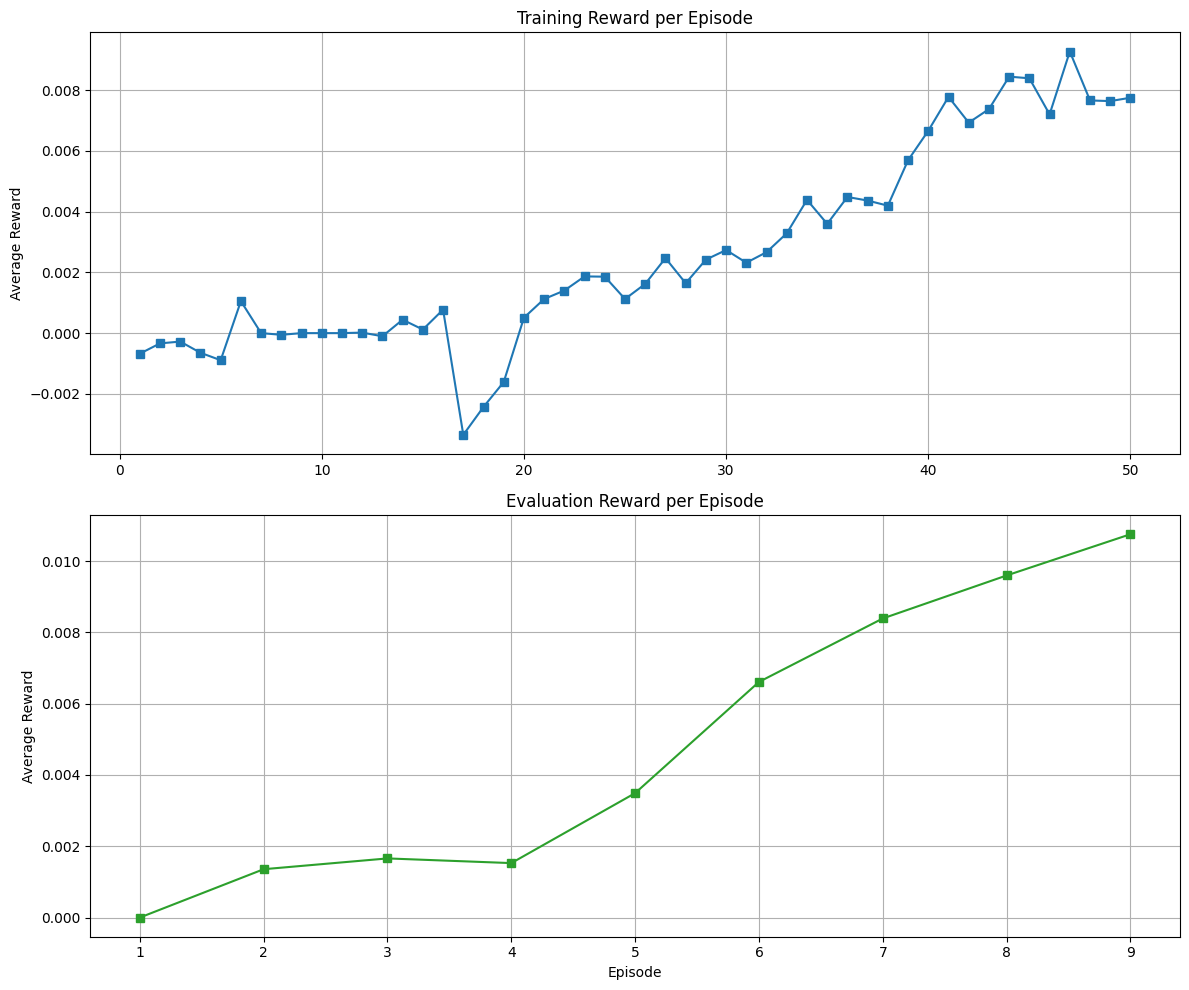

In [25]:
# Connect to the simulation database
engine = create_engine("sqlite:///../local_db/assume_db.db")

# Query rewards for specific simulation and unit
sql = """
SELECT
    datetime,
    unit,
    reward,
    simulation,
    evaluation_mode,
    episode
FROM rl_params
WHERE simulation = 'example_02e_base'
ORDER BY datetime
"""

# Load query results
rewards_df = pd.read_sql(sql, engine)

# Rename column for consistency
rewards_df.rename(columns={"evaluation_mode": "evaluation"}, inplace=True)

# --- Separate plots for training and evaluation ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Plot training rewards (evaluation == 0)
train_df = rewards_df[rewards_df["evaluation"] == 0]
train_grouped = train_df.groupby("episode")["reward"].mean()

axes[0].plot(train_grouped.index, train_grouped.values, "s-", color="tab:blue")
axes[0].set_title("Training Reward per Episode")
axes[0].set_ylabel("Average Reward")
axes[0].grid(True)

# Plot evaluation rewards (evaluation == 1)
eval_df = rewards_df[rewards_df["evaluation"] == 1]
eval_grouped = eval_df.groupby("episode")["reward"].mean()

axes[1].plot(eval_grouped.index, eval_grouped.values, "s-", color="tab:green")
axes[1].set_title("Evaluation Reward per Episode")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Average Reward")
axes[1].grid(True)

plt.tight_layout()
plt.show()

**What This Shows**

* **Training curve**: Captures learning progress with exploration noise.
* **Evaluation curve**: Tracks the performance of the evaluation/validation run without noise, which is performed every `validation_episodes_interval` steps, as defined in the `learning_config`. 

### 7.4 Exercise 4: Get a feeling for the Reward 

**Why is the reward so small?**
To better understand why the observed reward is so small, revisit the definition of the reward function. Pay particular attention to the aggregation function used in the plotting cell above. What exactly is being plotted?

Hint: Think about whether the plotted value reflects individual time steps or aggregated performance, and how inactive hours might affect the result.


**What happens to the individual units?**
The plot shows the **average reward** across both learning storage units. What would you expect the reward curve of a single storage unit to look like? Will it follow a similar trend, or could there be differences? Consider what impact one unit being more active or successful than the other might have on the average.

Take a moment to think through this before checking the explanation below.

**Solution Excerise 4**
The reward is based on the **scaled profit** of each storage unit:

```python
scaling = 1 / (self.max_bid_price * unit.max_power_discharge)
reward = scaling * profit
```

This scaling ensures that the reward stays within a small, consistent numerical range. Additionally, what is plotted is the average reward per time step across an entire episode — typically defined as one month, i.e., all hours within that month.

In many of these hours, the agent does not act (i.e., the profit is zero), which pulls the average down. If you change the aggregation function from `mean` to `sum`, you'll notice that the overall reward becomes larger, and you’ll see how the zero-reward hours affect the average.

By understanding this, you can better interpret agent performance and evaluate whether learning is actually occurring — even if the average reward appears small.

**Let's look at individual units**

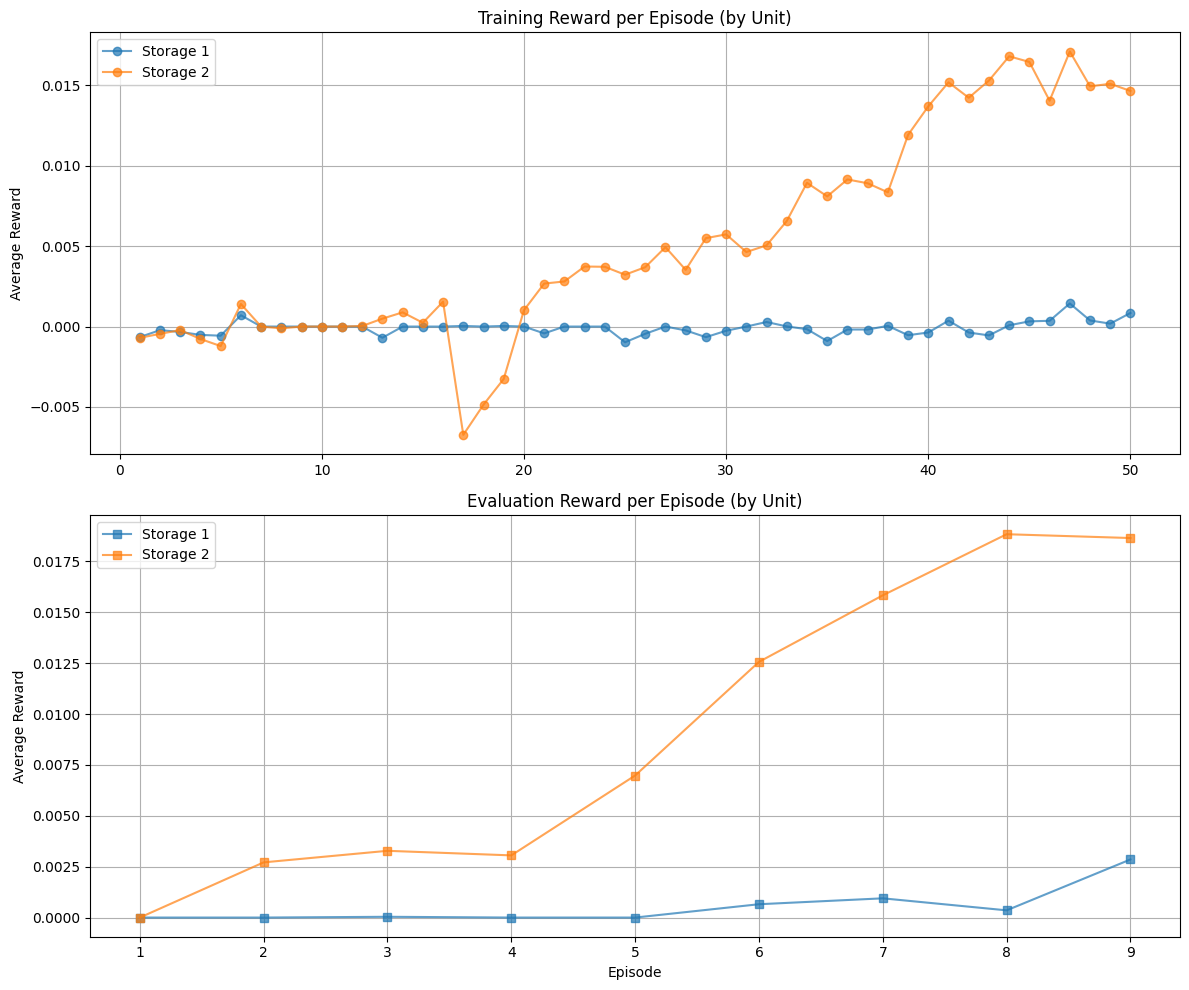

In [23]:
# Connect to the simulation database
engine = create_engine("sqlite:///../local_db/assume_db.db")

# Query rewards for specific simulation and unit
sql = """
SELECT
    datetime,
    unit,
    reward,
    simulation,
    evaluation_mode,
    episode
FROM rl_params
WHERE simulation = 'example_02e_base'
ORDER BY datetime
"""

# Load query results
rewards_df = pd.read_sql(sql, engine)

# Rename column for consistency
rewards_df.rename(columns={"evaluation_mode": "evaluation"}, inplace=True)

# Get unique units
units = rewards_df["unit"].unique()

# --- Separate plots for training and evaluation ---
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

# Plot training rewards (evaluation == 0) - one line per unit
train_df = rewards_df[rewards_df["evaluation"] == 0]
for unit in units:
    unit_data = train_df[train_df["unit"] == unit]
    train_grouped = unit_data.groupby("episode")["reward"].mean()
    axes[0].plot(
        train_grouped.index, train_grouped.values, "o-", label=f"{unit}", alpha=0.7
    )

axes[0].set_title("Training Reward per Episode (by Unit)")
axes[0].set_ylabel("Average Reward")
axes[0].legend()
axes[0].grid(True)

# Plot evaluation rewards (evaluation == 1) - one line per unit
eval_df = rewards_df[rewards_df["evaluation"] == 1]
for unit in units:
    unit_data = eval_df[eval_df["unit"] == unit]
    eval_grouped = unit_data.groupby("episode")["reward"].mean()
    axes[1].plot(
        eval_grouped.index, eval_grouped.values, "s-", label=f"{unit}", alpha=0.7
    )

axes[1].set_title("Evaluation Reward per Episode (by Unit)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Average Reward")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

As seen in the plots above, one storage unit (Storage 2) learns a profitable strategy, while the other (Storage 1) shows little to no improvement over time. This divergence is due to differences in initialisation and learning dynamics.

One key factor is that Storage 2 quickly learns that its actions can **influence the market price** — it becomes a price setter in certain hours. This feedback between its bidding strategy and the resulting price allows it to understand the reward signal more clearly and improve faster. In contrast, Storage 1 rarely becomes price-setting and thus finds it harder to link its actions to outcomes. Without this feedback loop, learning is significantly slower or even stagnant. Here we can see a slight increase in the evaluation rewrad ar the end, that indicates storage 1 might recover.

To mitigate this, we often use a **warm start** strategy in practice: agents are initialised with policies that have already learned basic behavioural patterns, such as first charge and then discharge or how to bid in a stationary environment. This helps agents reach the price-setting regime more quickly and facilitates meaningful learning, especially in multi-agent setups.


### 7.4 Summary

* You have now run your **first complete training loop** in ASSUME.
* The learning configuration defines all key training parameters—review them carefully.
* After training, rewards from `rl_params` allow you to inspect and validate agent behavior.
* The separation of **training** and **evaluation** rewards is key to understanding generalization.
* **Agent performance may vary significantly** due to initialisation and the ability to influence market prices.
* To support learning, agents are often **warm-started** with strategies that already capture basic bidding logic.

In the next chapter, you may proceed to analyze simulation outcomes in greater detail (e.g., market prices, total costs, capacity dispatch), or compare different agent configurations.

---

## 8. Analyzing Bidding Behavior

Now that your agent has completed training, we shift our focus to a critical and more insightful question:

> **What did the agent actually learn?**

This chapter analyzes the **actual bids submitted by the agent** and evaluates whether the agent developed a **reasonable bidding behavior**.


### 8.2. Extract and Plot the Agent's Bids

We will extract the bids submitted by `Storage 2` from the `market_orders` table and plot them over time.

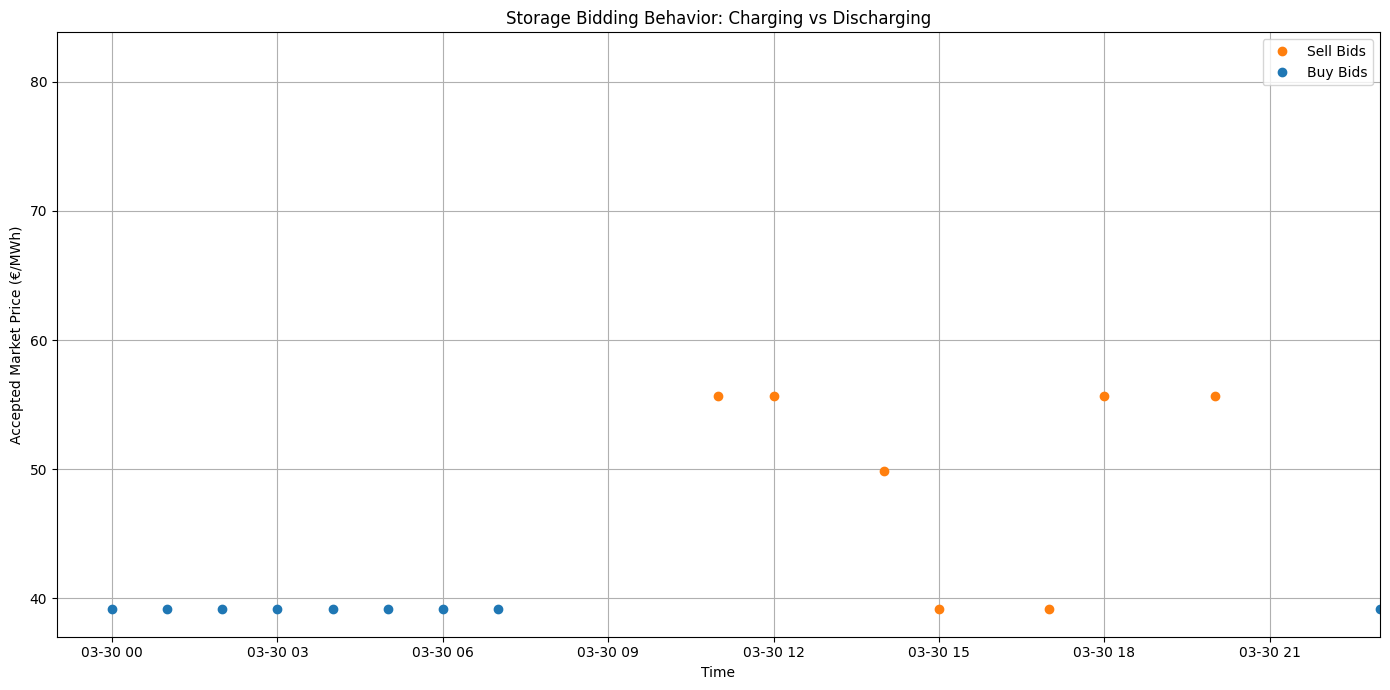

In [34]:
# Connect to database
engine = create_engine("sqlite:///../local_db/assume_db.db")

# Query bids from pp_6 in simulation example_02a_base and market EOM
sql = """
SELECT
    start_time AS time,
    accepted_price,
    unit_id,
    simulation,
    accepted_volume
FROM market_orders
WHERE simulation = 'example_02e_base'
  AND unit_id = 'Storage 2'
  AND market_id = 'EOM'
ORDER BY start_time
"""

bids_df = pd.read_sql(sql, engine)
bids_df["time"] = pd.to_datetime(bids_df["time"])

buy_bids = bids_df[bids_df["accepted_volume"] < 0].copy()
sell_bids = bids_df[bids_df["accepted_volume"] > 0].copy()

# plot sell and buy bids
plt.figure(figsize=(14, 7))
plt.plot(
    sell_bids["time"],
    sell_bids["accepted_price"],
    "o",
    label="Sell Bids",
    color="tab:orange",
)
plt.plot(
    buy_bids["time"],
    buy_bids["accepted_price"],
    "o",
    label="Buy Bids",
    color="tab:blue",
)


plt.title("Storage Bidding Behavior: Charging vs Discharging")
plt.xlabel("Time")
# just plot one day
plt.xlim(bids_df["time"].max() - pd.Timedelta(days=1), bids_df["time"].max())
plt.ylabel("Accepted Market Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 8.3. What Does This Show?

The plot above shows the **accepted market prices** for storage bids over time, separated into **buy bids** (charging) and **sell bids** (discharging). Each point represents a successful bid that was accepted by the market at a specific time.

- **Blue dots** indicate charging actions (buy bids), where the storage unit purchases electricity at lower prices.
- **Orange dots** represent discharging actions (sell bids), where electricity is sold back to the market at higher prices.

From the visual distribution, we can observe a typical storage behaviour:
- Charging occurs during **low-price hours**, typically at night or early morning.
- Discharging is concentrated in **higher-price hours**, typically in the afternoon or evening.

This indicates that the agent has learned a basic arbitrage strategy — **charge low, discharge high** — which aligns with economic incentives. The spread between buy and sell prices is essential for generating profit and, consequently, positive rewards.


While this gives insight into the **agent’s strategy and confidence**, it’s important to compare this behavior against a **benchmark** to judge its effectiveness.

- For a **single storage unit**, a common benchmark is a **perfect-foresight optimization**, which computes the best possible charging and discharging schedule based on known future prices. This shows how close the RL agent gets to the theoretical optimum.

- However, if you have **multiple storage agents**, their actions can **influence market prices**. In this case, the environment becomes **strategic and interdependent**, and a simple optimization no longer reflects the true benchmark.

- For such settings, the appropriate comparison is a **Mathematical Program with Equilibrium Constraints (MPEC)** or other game-theoretic models. These account for the fact that **agents anticipate their own market impact**, and provide a consistent equilibrium benchmark.

### 8.4. Summary

- You analyzed the learned bidding strategy of the storage unit. 
- Investigating how RL design choices impact market modeling results is crutial.
- Don't forget to benchmark your results to other models, e.g. optimization or game-theoretic models.

---


## 9. Summary and Outlook

### 9.1 What You Built

Over the course of this tutorial, you developed a complete **RL bidding strategy** for a storage unit in the **ASSUME** framework. You constructed and trained a learning agent that can:

* Observe market signals and internal state-of-charge dynamics.
* Decide when to charge or discharge based on learned economic strategies.
* Receive profit-based reward signals and adapt behavior over time.
* React to changing market conditions with temporally coordinated actions.


### 9.2 What You Learned

Throughout the tutorial, you explored the **end-to-end learning pipeline** for storage units in a realistic market setting:

* How to construct **observation spaces** that reflect temporal coupling and internal energy cost.
* How to define **bid direction and price** using a compact action space.
* Why **realized profit** is used as the reward signal, and why opportunity cost is avoided for storage.
* How to scale rewards and update the **cost of stored energy** after market interactions.
* How to train and evaluate a storage agent’s behavior in **multi-agent DRL simulations**.

### 9.3 What You Can Try Next

Your implementation is modular and extensible. Here are several directions you can explore on your own:

1. **Adjust Learning Parameters**

Experiment with:

* `learning_rate`, `gamma`, `noise_sigma`, `episodes_collecting_initial_experience`
* `validation_episodes_interval`, `train_freq`, or `gradient_steps`

Observe how these changes affect convergence, stability, and bidding behavior.

2. **Try Different Scenarios**

* Adjust scenario inputs of example `02e`:

  * Remove the second storage unit from the `storage_units.csv` file.
  * Add many learning agents, simulating a highly competitive environment.

* Compare bidding behavior and reward dynamics across settings.

3. **Dive into other tutorials**

* If you are interested in the general algorithm behind the MADDPG and how it is integrated into ASSUME look into [04a_RL_algorithm_example](.\04a_reinforcement_learning_algorithm_example.ipynb) 
* In the small example we could see what the a good bidding behavior of the agent might be and, hence, can judge learning easily, but what if we model many agents in new simulations? We provide explainable RL mechanisms in another tutorial for you to dive into [09_example_Sim_and_xRL](.\09_example_Sim_and_xRL.ipynb) 
